# LSTM网络实现RNN写作生成

**任务要求：利用LSTM网络实现RNN的莎士比亚风格文本写作生成。**  
**数据: shakespeare.txt**

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import unidecode
import string
import random
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
use_gpu = True if torch.cuda.is_available() else False
print('Use GPU:', use_gpu)

Use GPU: False


## 1. 加载文本数据

加载训练文本数据及字符集

In [5]:
all_characters = string.printable
n_characters = len(all_characters)
print('characters num:', n_characters)
print(all_characters)

file = unidecode.unidecode(open('./data/shakespeare.txt').read())
file_len = len(file)
print('file length:', file_len)

characters num: 100
0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

file length: 1115394


### 随机文本块

In [6]:
chunk_len = 500
#500

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index: end_index]

print(random_chunk())

 through with
all.

ESCALUS:
Look you bring me in the names of some six or seven,
the most sufficient of your parish.

ELBOW:
To your worship's house, sir?

ESCALUS:
To my house. Fare you well.
What's o'clock, think you?

Justice:
Eleven, sir.

ESCALUS:
I pray you home to dinner with me.

Justice:
I humbly thank you.

ESCALUS:
It grieves me for the death of Claudio;
But there's no remedy.

Justice:
Lord Angelo is severe.

ESCALUS:
It is but needful:
Mercy is not itself, that oft looks so;
Pardon 


### 随机数据-标签对

In [7]:
def char_tensor(string):
    n = len(string)
    t = torch.zeros(n).long()
    for i in range(n):
        t[i] = all_characters.index(string[i])
    return Variable(t)
print(all_characters)
print(char_tensor('(abcdef,ABCDEF).'))

0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

tensor([69, 10, 11, 12, 13, 14, 15, 73, 36, 37, 38, 39, 40, 41, 70, 75])


In [8]:
def random_training_set():
    chunk = random_chunk()
    inputs = char_tensor(chunk[:-1])
    targets = char_tensor(chunk[1:]) #每个字符到后一个字符
    return inputs, targets

random_training_set()

(tensor([15, 10, 29, 17, 14, 27, 73, 94, 11, 14, 21, 18, 20, 14, 75, 94, 58, 17,
         24, 94, 20, 23, 24, 32, 28, 94, 29, 17, 10, 29, 94, 47, 24, 13, 24, 32,
         18, 12, 20, 82, 96, 96, 47, 56, 38, 44, 50, 77, 96, 48, 34, 94, 21, 24,
         27, 13, 73, 94, 44, 94, 20, 23, 24, 32, 94, 17, 18, 22, 78, 94, 68, 29,
         18, 28, 94, 10, 94, 22, 14, 13, 13, 21, 18, 23, 16, 94, 15, 27, 18, 10,
         27, 78, 96, 44, 94, 13, 24, 94, 23, 24, 29, 94, 21, 18, 20, 14, 94, 29,
         17, 14, 94, 22, 10, 23, 77, 94, 17, 10, 13, 94, 17, 14, 94, 11, 14, 14,
         23, 94, 21, 10, 34, 73, 94, 22, 34, 94, 21, 24, 27, 13, 96, 41, 24, 27,
         94, 12, 14, 27, 29, 10, 18, 23, 94, 32, 24, 27, 13, 28, 94, 17, 14, 94,
         28, 25, 10, 20, 14, 94, 10, 16, 10, 18, 23, 28, 29, 94, 34, 24, 30, 27,
         94, 16, 27, 10, 12, 14, 96, 44, 23, 94, 34, 24, 30, 27, 94, 27, 14, 29,
         18, 27, 14, 22, 14, 23, 29, 73, 94, 44, 94, 17, 10, 13, 94, 28, 32, 18,
         23, 16, 14, 13, 94,

## 2. RNN模型

利用PyTorch构建RNN模型类，内部包括Embedding层、LSTM、FC层

In [9]:
''' 请在下方编写RNN模型类 '''

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNN, self).__init__()
        
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.output_size=output_size
        self.num_layers=num_layers
        
        self.embedding = nn.Embedding(num_embeddings=100, embedding_dim=input_size)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size)
        self.fc = nn.Linear(in_features=hidden_size, out_features=output_size)
        
    def forward(self, inputs, hidden):
        
        o1=self.embedding(inputs.view(1,-1)) #转为2维[[]] 经过embedding后变成三维[[[]]]
        o2,(h,c)=self.lstm(o1,hidden) #返回值是 output , (h,c)  
        outputs=self.fc(o2) 
        hidden=(h,c)
        
        return outputs, hidden
    
    def init_hidden(self):
        h0= Variable(torch.zeros(self.num_layers,1,self.hidden_size))#(1,1,100)
        c0= Variable(torch.zeros(self.num_layers,1,self.hidden_size))
        return h0, c0

## 3. 训练函数

In [10]:
def train(inputs, target):
    h, c = rnn.init_hidden()
    if use_gpu:
        inputs = inputs.cuda()
        target = target.cuda()
        h, c = h.cuda(), c.cuda()
    hidden = (h, c)
    
    loss = 0
    for i in range(len(inputs)):
        ''' 请在下方编写rnn模型输出，及loss累加代码'''
        output,hidden=rnn.forward(inputs[i],hidden)

        loss+=criterion(output.view(1,100),target[i].view(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.data.item()/len(inputs)

## 4. 文本生成测试函数

In [11]:
def test(prime_str='A', predict_len=100, temperature=0.8):
    h, c = rnn.init_hidden()
    prime_input = char_tensor(prime_str)#'Th'

    if use_gpu:
        h, c = h.cuda(), c.cuda()
        prime_input = prime_input.cuda()
    predicted = prime_str
    
    for i in range(len(prime_str)-1):
        _, (h, c) = rnn(prime_input[i], (h, c))
    inputs = prime_input[-1]

    for p in range(predict_len):
        if use_gpu:
            inputs = inputs.cuda()
        output, (h, c) = rnn(inputs, (h, c))
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inputs = char_tensor(predicted_char)
    
    return predicted

## 5. 模型训练

#### 超参数

In [12]:
''' 请自行设定相关参数 '''
epoch_num = 2000  # 1000~10000
print_every = 100
plot_every = 10
hidden_size = 100
num_layers = 1
lr = 0.01

#### 模型、优化器、损失函数

In [13]:
# RNN模型
rnn = RNN(n_characters, hidden_size, n_characters, num_layers)
if use_gpu:
    rnn = rnn.cuda()
print(rnn)

RNN(
  (embedding): Embedding(100, 100)
  (lstm): LSTM(100, 100)
  (fc): Linear(in_features=100, out_features=100, bias=True)
)


In [14]:
# 优化器
''' 请在下方编写Adam优化器定义的代码 '''
optimizer = torch.optim.Adam(rnn.parameters(),lr=lr)
print(optimizer)

# 损失函数
''' 请在下方编写交叉熵损失函数定义的代码 '''
criterion = nn.CrossEntropyLoss()
print(criterion)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)
CrossEntropyLoss()


#### 模型训练

In [15]:
time_start = time.time()
evaluate = True  # 可设置为False，训练过程中不评估
loss_list = []
loss_avg = 0

for epoch in range(1, epoch_num+1):
    inputs, targets = random_training_set()
    loss = train(inputs, targets)
    loss_avg += loss
    
    if epoch % print_every == 0:
        print('[Time: %ds  Epoch: %d (%d%%)  Loss: %.4f]'%(int(time.time()-time_start), epoch, epoch/epoch_num*100, loss))
        if evaluate:
            pred_text = test('Th', 200)
            print(pred_text, '\n')
        
    if epoch % plot_every == 0:
        loss_list.append(loss_avg/plot_every)
        loss_avg = 0
# #保存模型
# torch.load(rnn,'rnn.pkl')

[Time: 21s  Epoch: 100 (5%)  Loss: 2.3108]
Thus wen son of
To werly at but our you come there that bere it hand ang al is hitherme tins and herad his hinons, him cime a buth or buss yeam, oug sher.

OLIO:
:ou who, and orn, mand preathen.

GLUS:
 

[Time: 43s  Epoch: 200 (10%)  Loss: 2.0120]
Thou me lord mads matgere.

DUSS:
Bo by of whome Enmes yout, all were in a mowser as for
ent a Yenrt wermalf een's it and you comer theid they mives bearting ay, man to to me heary and for golle my king 

[Time: 64s  Epoch: 300 (15%)  Loss: 2.0550]
Th:
He me thou pate ance, sate I lanted,
Thou leak is hing oft not mity and liocy.

ROMIS:

PETRUMIO:
Whe mans: the mod, aut suckme, at his se the net if brome wit as that frice that the not youd spore  

[Time: 85s  Epoch: 400 (20%)  Loss: 1.9755]
Thr all wea, hate caneded have dears, then me love and of may, not mineate what thour onsureather wake to his vareade
And day appentlough love menan the a for trays, to on your tack not sweak reting les 

[Time

## 6. 训练Loss曲线

绘制训练过程中的Loss曲线

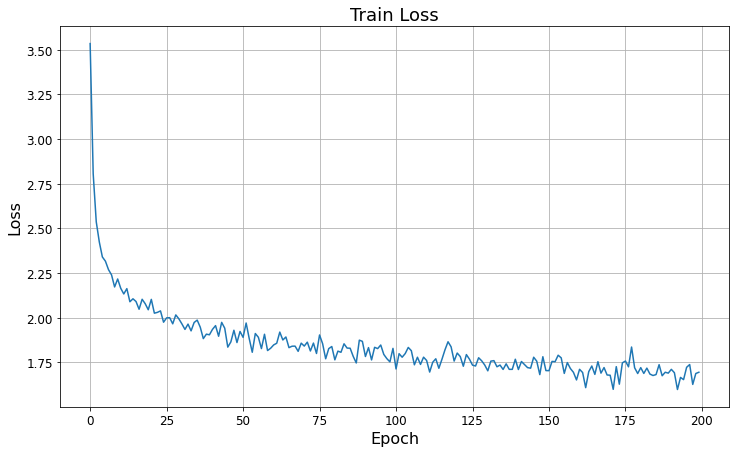

In [16]:
plt.figure(figsize=(12, 7))
plt.plot(loss_list)
plt.title('Train Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()

## 7. 测试

自定义初始字符和文本长度以生成文本

In [17]:
test_text = test('My', 1000, 0.8)
print(test_text)

My Citizen thing
how cause he corchape the plored exe a beas in these with make,
And be got to tell father the now,
The flies have and slease the conspace this to like, but proce going in bettith the witermenes rook.
Who dreak I words they say the depoone and seed
Thou dednable, the death?
GONZALO:
Nother to the cellight, you perap,
And in vatiend that have prorlone withs swasteng our tears:
Come, in of was time to the did vace:
The dear pe think this desent give the desent roy me in thou to them;
Mand the stunds, pispelf;
And their loven of the mane fearful a was the this have raped of whole? Gday the to try specoor,
And do preat to news.

BRUTUS:
Why, I say to my lords, my satten be are be the princes,
Their gooshath is soness is can, by so calown,
My god his pering the worson the worse?

MENENIUS:
Firson hyselfives how the spake these be plarity way of the plainting
The two here quit and do appand
That the son: man, and they paring to leness.

BRUTUS:
And face: pole of here lesing f

In [18]:
test_text = test('To be or not to be', 1000, 0.8)
print(test_text)

To be or not to be fares by the have it
The done shall effect this for then he death the siff this we was the conglatteares Lord suh in more the tame though me to princes:
Your so was ben of I we it not do the pray do Turn with the royor my it tall of herent your mark'd a conson upon the chair from nor fail surds to the person with the plores, mine
The govench things sucts!
That of the dighour it be since
And the poor copleas: king: were reparst and not death,

AUTOKE:
He so safe lovenge sues and to the rasse;
The proce and done the not
The be me bear till the fast Clive I many to thee consue. Why flese.

TRANION:
It the protes love;
The man; not your good mine person that do a cound be not
the unterm'd hath kenge of meanat,
Where mine to beater of did not for thing to me a frong things, and sir, they she water we then to comite their hath her hath their persed spirely say hers?

KING EDWARD IV:
Nexped as it me hast of my a honess morace better
too Mardself, so the pity
The come is you